# Make Feature Dataframes for machine learning

This notebook's goal is to make dfs for machine learning algorithm. These will be exported and then combined in different ways to find the optimal combination of columns to be used in a machine learning algorithm. 

Thing to follow up on:

See how scaling (making the mean equal to 0 and the variance equal to 1) impacts the testing accuracy of machine learning models.

### Combining csv data files into one df

In [13]:
#import necessary modules
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
from scipy.signal import periodogram    # routine to find power spectrum
from scipy.signal import savgol_filter  # routine to smooth power spectrum
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import datasets 
from sklearn.model_selection import train_test_split
from itertools import combinations

#find where the files combining from
path = os.getcwd()
files = os.listdir(path)
#get the files that end with '.xlsx' and '.xls'
csvfiles = [os.path.join(root, name)
             for root, dirs, files in os.walk(path)
             for name in files
             if name.endswith((".csv"))]
print('Number of spreadsheets: ' + str(len(csvfiles)))

Number of spreadsheets: 128


In [14]:
#make empty list
subfiles = []
#loop through csvfiles (location of csv files)
for i in range(len(csvfiles)):
    #read csv file
    file = pd.read_csv(csvfiles[i])
    #add df into subfiles
    subfiles.append(file)

#combine subfiles into one file
allfiles = pd.concat(subfiles[:], sort=True)

#select columns
allfiles = allfiles[['time','x','y','z','subject','attempt']]
print('With Nans: ' + str(len(allfiles)))
#drop nan rows
allfiles = allfiles.dropna()
print('Without Nans: ' + str(len(allfiles)))

#array of first character in attempt column, change into float, divide be 10
first = allfiles.attempt.astype(str).str[0].values.astype(float)/10
#array of subject numbers
subject = allfiles.subject.values

#make empty array
Id = []
#loop through length of allfiles
for i in range(len(allfiles.subject)):
    #make sure decimal is float
    decimal = float(first[i])
    #make sure sub is float
    sub = float(subject[i])
    #add both
    idnum = sub + decimal
    #add it to a new array
    Id.append(idnum)

#add ID column of new numbers
allfiles['ID']=Id

With Nans: 256781
Without Nans: 256779


### Get the x,y, and z velocity frequencies and make df

In [15]:
#make variable to loop through with all subject names and attempts
subject = np.unique(allfiles.ID)

#make empty lists (may not be necessary)
tremor_ns = [] # list to hold the resampled dataframe for each subject
divsec_ns = 0.100  # value of resampling time chosen
tremor_label_ns = [] # list to hold the plot labels for each subject
tremor_vel_ns = []  # list to hold the velocity dataframes for each subject
f_ns = []     # lists to contain all power spectra
psd_ns = []   # lists to contain all power spectra
favg_ns = []
psdtot_ns = []

for ol in range(len(subfiles)):
    #loop through list of csv files
    tremor = subfiles[ol]
# read in subject, convert to datetime, remove unnecessary columns
    tremor.index = pd.to_datetime(tremor.time, unit='s')
    tremor = tremor.drop(['subject','attempt'],axis=1)

    # create list of resampled time series for current subject
    tremor_ns.append(tremor.resample('100ms').mean())
    tremor_label_ns.append(['subject '+str(subject[ol])+', sampling rate = 0.1 s'])

    # subtract off position offset from each time series for current subject    
    tremor_ns[ol] = tremor_ns[ol] - tremor_ns[ol].iloc[0,0:4]

    # calculate velocity dataframe for each time series
    displacement = tremor_ns[ol].iloc[:,1:].diff()
    velocity = displacement.div(divsec_ns)
    velocity = velocity.drop(velocity.index[0],axis=0)  # get rid of first row w/ no data
    velocity.rename(columns = {'x':'vx'}, inplace = True) # rename columns
    velocity.rename(columns = {'y':'vy'}, inplace = True)
    velocity.rename(columns = {'z':'vz'}, inplace = True)
    tremor_vel_ns.append(velocity)

    # code to record power spectra in all three directions and
    # calculate measures (avg frequency and total summed power) from the power spectra

    f_coord = []  # list to contain x,y,z coordinates
    psd_coord = []  # list to contain x,y,z coordinates
    favg_coord = []  # average value of frequency (weighted by amplitude)
    psdtot_coord = []  # total summed amplitude
    for lo in range(3):  # 3 is for 3 dimensions (x,y,z)
        velocity_array = tremor_vel_ns[ol].to_numpy()  # convert df to numpy array
        varray = velocity_array[:,lo]  # extract appropriate coordinate (x,y,z) from array
        t_array = np.arange(len(varray))*divsec_ns  # create time array matching freq
        sample_freq = 1.0/divsec_ns  # find sample frequency in Hertz
        # use periodogram to find the power spectrum of current coordinate x,y,z
        f, psd = periodogram(varray, fs=sample_freq, window=None, nfft=None,\
            detrend='constant', return_onesided=True, scaling='density', axis=-1)
        psd_filter = savgol_filter(psd,5,3)  # do a little smoothing to make plot easier to read
        f_coord.append(f)   # add to coordinate lists
        psd_coord.append(psd_filter)
        # calculate average value of psd
        nf = len(f)   # numbery of frequency
        df = f[1]-f[0]  # frequency interval
        frange = f[-1]-f[0] # range of frequencies
        psd_tot = 0.0  # start integral at zero
        for il in range(nf):
            psd_tot += psd[il]*df  # multiply value by df within integral
        psdtot_coord.append(psd_tot/frange)  # divide by range to get average value
        favg_tot = 0.0   # start integral at zero
        for il in range(nf):
            favg_tot += f[il]*psd[il]*df  # add weighted sum of f 
        favg_coord.append(favg_tot/psd_tot)  # divide by psd_tot integral to get favg
    psdtot_ns.append(psdtot_coord)
    favg_ns.append(favg_coord)
    f_ns.append(f_coord)  # add to resample frqeuency lists
    psd_ns.append(psd_coord)

### Visualize the x,y, and z velocity frequencies and PSDs

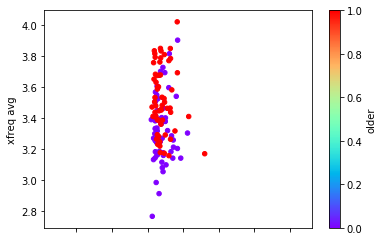

In [16]:
# create a dataframe from the subject numbers and x-data, and add a binary column on age
subjectarray = np.array(subject).reshape(-1,1)
psdtot_ns_array = np.array(psdtot_ns)
psdarray_x = psdtot_ns_array[:][:,0].reshape(-1,1)
favg_ns_array = np.array(favg_ns)
favgarray_x = favg_ns_array[:][:,0].reshape(-1,1)
xdf = pd.DataFrame(np.hstack((subjectarray,psdarray_x,favgarray_x)))
xdf.columns = ['subject no','xpsd avg','xfreq avg']
xdf['older'] = np.where(xdf['subject no']>=200, 1, 0)
xdf.plot.scatter(x='xpsd avg', y='xfreq avg', c='older', colormap='rainbow')

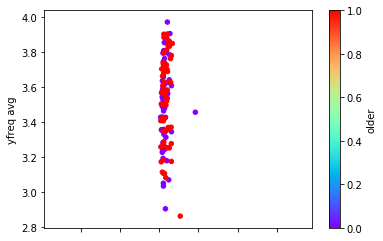

In [17]:
# create a dataframe from the subject numbers and y-data, and add a binary column on age
subjectarray = np.array(subject).reshape(-1,1)
psdtot_ns_array = np.array(psdtot_ns)
psdarray_y = psdtot_ns_array[:][:,1].reshape(-1,1)
favg_ns_array = np.array(favg_ns)
favgarray_y = favg_ns_array[:][:,1].reshape(-1,1)
ydf = pd.DataFrame(np.hstack((subjectarray,psdarray_y,favgarray_y)))
ydf.columns = ['subject no','ypsd avg','yfreq avg']
ydf['older'] = np.where(ydf['subject no']>=200, 1, 0)
ydf.plot.scatter(x='ypsd avg', y='yfreq avg', c='older', colormap='rainbow')

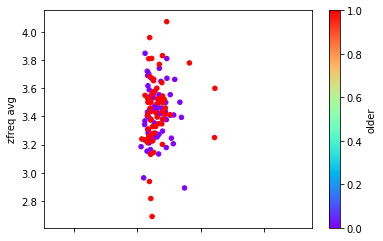

In [18]:
# create a dataframe from the subject numbers and z-data, and add a binary column on age
subjectarray = np.array(subject).reshape(-1,1)
psdtot_ns_array = np.array(psdtot_ns)
psdarray_z = psdtot_ns_array[:][:,2].reshape(-1,1)
favg_ns_array = np.array(favg_ns)
favgarray_z = favg_ns_array[:][:,2].reshape(-1,1)
zdf = pd.DataFrame(np.hstack((subjectarray,psdarray_z,favgarray_z)))
zdf.columns = ['subject no','zpsd avg','zfreq avg']
zdf['older'] = np.where(zdf['subject no']>=200, 1, 0)
zdf.plot.scatter(x='zpsd avg', y='zfreq avg', c='older', colormap='rainbow')

In [19]:
#set 'subject no' as index of dataframes
xdf.set_index('subject no', inplace=True)
ydf.set_index('subject no', inplace=True)
zdf.set_index('subject no', inplace=True)

In [20]:
#select for columns besides 'older' in xdf and ydf so it's not repeated
xdf_avg = xdf[['xpsd avg', 'xfreq avg']]
ydf_avg = ydf[['ypsd avg', 'yfreq avg']]

#combine the dataframes
vel_freq = pd.concat([xdf_avg,ydf_avg,zdf], axis=1)

#export to csv
vel_freq.to_csv('Velocity_Frequencies.csv', index=False)

vel_freq.head()

,xpsd avg,xfreq avg,ypsd avg,yfreq avg,zpsd avg,zfreq avg,older
subject no,,,,,,,
100.1,0.001027,3.271790,0.000219,3.563819,0.001316,3.253807,0
100.2,0.000960,3.363329,0.000208,3.427613,0.001020,3.165234,0
101.1,0.000924,3.367080,0.000181,3.490563,0.001085,3.671680,0
101.2,0.000991,3.405149,0.000324,3.613180,0.001719,3.741220,0
102.1,0.000568,3.335554,0.000309,3.541869,0.000904,3.393152,0


### Get the x,y, and z stats and make df

In [21]:
#set index of allfiles as the datetime of 'time'
allfiles.index=pd.to_datetime(allfiles.time, unit='s')

#make variable for unique values in 'ID'
uni_id = np.unique(allfiles.ID)

#make empty lists
resampled = []
x_tot_d = []
y_tot_d = []
z_tot_d = []
tot_d = []
xdiff_stats = []
ydiff_stats = []
zdiff_stats = []

#loop through unique names in 'ID'
for i in uni_id:
    #make df for each unique value in ID, resample it by 100ms and mean
    dfi = allfiles[allfiles.ID == i].resample('150ms').mean()
    #get the offset vector
    offset_vector = dfi.iloc[0,0:6]
    offset_vector[-1] = 0
    #subtract the offset vector to normalize the dfs
    dfi = dfi - offset_vector
    #make columns for the difference from previous x,y,z position
    dfi['xdiff'] = dfi.x.diff()
    dfi['ydiff'] = dfi.y.diff()
    dfi['zdiff'] = dfi.z.diff()
    #make column for total distance from last positon
    dfi['dist_from_l'] = np.sqrt(dfi.xdiff**2 + dfi.ydiff**2 + dfi.zdiff**2)
    #get absolute from the x,y, and z differences and sum the first 25 seconds
    x_d = dfi.xdiff.abs()[:170].sum()
    y_d = dfi.ydiff.abs()[:170].sum()
    z_d = dfi.zdiff.abs()[:170].sum()
    total_d = dfi.dist_from_l[:170].sum()
    #get summary stats of 
    xdiff_s = dfi.xdiff.describe()
    ydiff_s = dfi.ydiff.describe()
    zdiff_s = dfi.zdiff.describe()
    #add the total distances to respective variables
    x_tot_d.append(x_d)
    y_tot_d.append(y_d)
    z_tot_d.append(z_d)
    tot_d.append(total_d)
    xdiff_stats.append(xdiff_s)
    ydiff_stats.append(xdiff_s)
    zdiff_stats.append(xdiff_s)
    #add dfi to list of resampled dataframes
    resampled.append(dfi)

#combine the list of dataframes
resample = pd.concat(resampled)

#fill in the ID values that very lost from using the offset vector
resample.ID = resample.ID.replace(0.0, np.nan).fillna(method='bfill')
resample.head()

,time,x,y,z,subject,ID,xdiff,ydiff,zdiff,dist_from_l
time,,,,,,,,,,
1970-01-01 00:00:00.000,0.000000,0.000000,0.000000,0.000000,0.0,100.1,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.150,0.149359,-0.006481,-0.002391,0.001938,0.0,100.1,-0.006481,-0.002391,0.001938,0.007175
1970-01-01 00:00:00.300,0.298739,-0.000642,-0.007271,-0.002297,0.0,100.1,0.005839,-0.004880,-0.004235,0.008709
1970-01-01 00:00:00.450,0.448160,-0.006233,-0.005443,-0.003307,0.0,100.1,-0.005590,0.001828,-0.001010,0.005968
1970-01-01 00:00:00.600,0.597548,-0.005803,-0.002282,0.006714,0.0,100.1,0.000430,0.003161,0.010021,0.010517


In [22]:
#make empty lists
new_x = []
new_y = []
new_z = []
#loop through the length of the x,y,z diff_stats lists
for i in range(len(xdiff_stats)):
    #make each element into a df
    datax = pd.DataFrame(xdiff_stats[i])
    datay = pd.DataFrame(ydiff_stats[i])
    dataz = pd.DataFrame(zdiff_stats[i])
    #transform each df
    datax = datax.T
    datay = datay.T
    dataz = dataz.T
    #add each df to its own list
    new_x.append(datax)
    new_y.append(datay)
    new_z.append(dataz)

#make list for the new lists, x,y,z letters 
stats_list = [new_x,new_y,new_z]
letter = ['x','y','z']
#make empty list
direction_df = []
#loop through the length of stats lists
for i in range(len(stats_list)):
    #concatenate the list of translated dfs in the stats_list element
    direction = pd.concat(stats_list[i])
    #change the columns names of the combined df
    direction.columns = [letter[i]+'count',letter[i]+'mean',letter[i]+'std',letter[i]+'min',letter[i]+'25%',letter[i]+'50%',letter[i]+'75%',letter[i]+'max']
    #select for the columns that are not 'count'
    direction = direction[[letter[i]+'mean',letter[i]+'std',letter[i]+'min',letter[i]+'25%',letter[i]+'50%',letter[i]+'75%',letter[i]+'max']]
    #set index to the range of the length of one of the columns
    direction.index = range(len(direction[letter[i]+'std']))
    #add new df to direction_df
    direction_df.append(direction)

#combine the dfs in direction_df by their index column
xyz_stats = pd.concat(direction_df, axis=1)
#add an ID column
xyz_stats['ID'] = uni_id
#add an 'older' column
xyz_stats['older'] = np.where(xyz_stats['ID']>=200, 1, 0)
#get rid of 'ID' columns
xyz_stats = xyz_stats.drop(['ID'], axis=1)

#export to csv
xyz_stats.to_csv('xyz_stats.csv', index=False)

### Get the x,y, and z total distances and make df

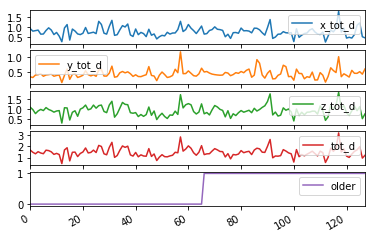

In [23]:
#make new dataframe
distance = pd.DataFrame()

#add columns for subject ID, x,y,and z total distance, and total distance
distance['ID'] = np.unique(allfiles.ID)
distance['x_tot_d'] = x_tot_d
distance['y_tot_d'] = y_tot_d
distance['z_tot_d'] = z_tot_d
distance['tot_d'] = tot_d

#make column 'older' so that if 'ID' value is greater than 200 than it is 1
distance['older'] = np.where(distance.ID>=200, 1, 0)
#drop ID column
distance = distance.drop(columns=['ID'],axis=1)

#plot
distance.plot(subplots=True)
plt.show()

#export to csv
distance.to_csv('total_distances.csv', index=False)